# Neural Networks Learning

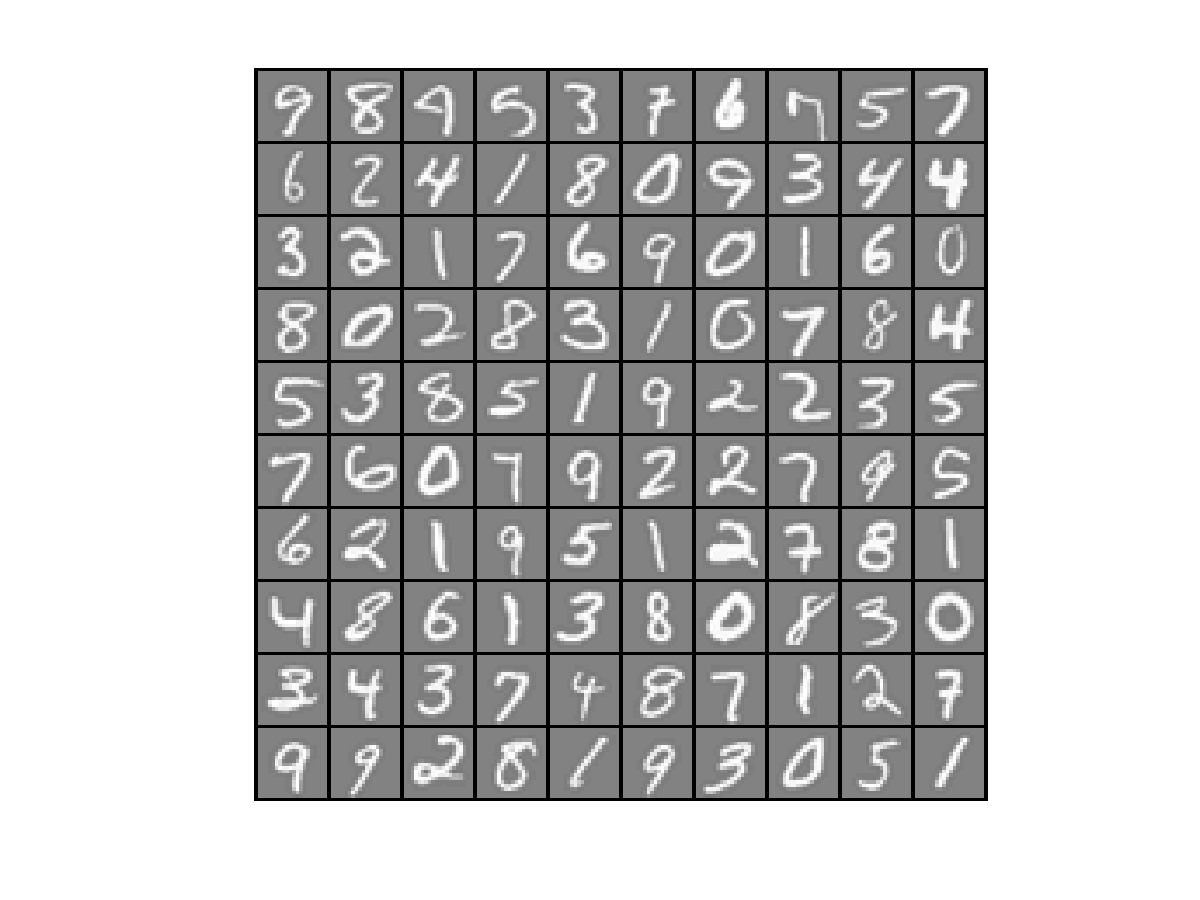

In [33]:
input_layer_size = 400;
hidden_layer_size = 25;
num_labels = 10;

load('ex4data1.mat');
m = size(X, 1);
sel = randperm(m);
sel = sel(1:100);
displayData(X(sel, :));

パラメータのアンロール

In [11]:
load('ex4weights.mat');
nn_params = [Theta1(:) ; Theta2(:)];

## Feedforward and cost function

3 レイヤーのニューラルネットを考える

$$
J(\theta) = {1 \over m}
\sum_{i=1}^m\sum_{k=1}^K[
-y_k^{(i)}log((h_\theta(x^{(i)}))_k)
-(1-y_k^{(i)})log(1 - (h_\theta(x^{(i)}))_k)
]
$$

$$
\Theta^{(j)} \in \mathbb{R}^{s_{j+1} \times s_j+1}
$$

$$
\begin{eqnarray}
z^{(2)} & = & \Theta^{(1)}x \\
a^{(2)} & = & g(z^{(2)})\\
a^{(3)} & = & g(\Theta^{(2)}a^{(2)}) = h_\theta(x)
\end{eqnarray}
$$

### Regularized cost function

$$
J(\theta) = {1 \over m}
    \sum_{i=1}^m\sum_{k=1}^K[
    -y_k^{(i)}log((h_\theta(x^{(i)}))_k)
    -(1-y_k^{(i)})log(1 - (h_\theta(x^{(i)}))_k)
] + {\lambda \over 2m}[
    \sum_{l=1}^{L-1}\sum_{j=1}^{s_l}\sum_{k=1}^{s_{l-1}}(
        \Theta_{j,k}^{(l)}
    )^2
]
$$

In [51]:
function [J grad] = nnCostFunction(nn_params, input_layer_size, ...
                                                              hidden_layer_size, num_labels, ...
                                                              X, y, lambda)
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                                    hidden_layer_size, (input_layer_size + 1));
    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                                    num_labels, (hidden_layer_size + 1));
    m = size(X, 1);
    J = 0;
    Theta1_grad = zeros(size(Theta1));
    Theta2_grad = zeros(size(Theta2));
    
    X = [ones(m, 1), X];
    a2 = sigmoid(Theta1* X');
    a2 = [ones(1, m); a2];
    hx = (sigmoid(Theta2 * a2))';

    for i = 1:m,
        vy = zeros(num_labels, 1);
        vy(y(i)) = 1;
    
        for k = 1:num_labels,
            J = J + (-1 * vy(k) * log(hx(i, k))) - ((1 - vy(k)) * log(1 - hx(i, k)));
        end;
    end;
    J = J / m;
    
    % 正規化項
    reg = 0;
    for j = 1:hidden_layer_size,
        % k = 1 のカラムはバイアスユニットなので正規化しない
        % またサイズはバイアスユニットの分 + 1 しないといけない
        for k = 2:(input_layer_size+1),
            reg = reg + Theta1(j, k)^2;
        end;
    end;
    for j = 1:num_labels,
        for k = 2:(hidden_layer_size+1),
            reg = reg + Theta2(j, k)^2;
        end;
    end;
    reg = reg * lambda / (2 * m);
    J = J + reg;
endfunction;

In [52]:
lambda = 0;
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, ...
                   num_labels, X, y, lambda);

fprintf(['Cost at parameters (loaded from ex4weights): %f '...
              '\n(this value should be about 0.287629)\n'], J);

Cost at parameters (loaded from ex4weights): 0.287629 
(this value should be about 0.287629)


In [53]:
lambda = 1;
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, ...
                   num_labels, X, y, lambda);

fprintf(['Cost at parameters (loaded from ex4weights): %f '...
              '\n(this value should be about 0.383770)\n'], J);

Cost at parameters (loaded from ex4weights): 0.383770 
(this value should be about 0.383770)


### Sigmoid gradient

$$
g'(z) = { d \over dz}g(z) = g(z)(1 - g(z))
$$

In [56]:
function g = sigmoidGradient(z)
    g = sigmoid(z) .* (1 - sigmoid(z));
endfunction

g = sigmoidGradient([1 -0.5 0 0.5 1]);
fprintf('Sigmoid gradient evaluated at [1 -0.5 0 0.5 1]:\n  ');
fprintf('%f ', g);

Sigmoid gradient evaluated at [1 -0.5 0 0.5 1]:
  
0.196612 0.235004 0.250000 0.235004 0.196612 


### Random initialization

In [61]:
function W = randInitializeWeights(L_in, L_out)
    epsilon_init = 0.12;
    W = rand(L_out, 1 + L_in) ...
            * 2 * epsilon_init - epsilon_init;
endfunction

initial_Theta1 = randInitializeWeights(...
                                input_layer_size, hidden_layer_size);
initial_Theta2 = randInitializeWeights(...
                                hidden_layer_size, num_labels);

initial_nn_params = [initial_Theta1(:) ; initial_Theta2(:)];

## Backpropagation

$$
\begin{eqnarray}
\delta^{(3)} & = & a^{(3)} - y \\
\delta^{(2)} & = & (\Theta^{(2)})^T .* g'(z^{(2)})
    = (\Theta^{(2)})^T .* (a^{(2)} .* (1 - a^{(2)}))
\end{eqnarray}
$$

In [112]:
function [J grad] = nnCostFunction(nn_params, input_layer_size, ...
                                                              hidden_layer_size, num_labels, ...
                                                              X, y, lambda)
    Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), ...
                                    hidden_layer_size, (input_layer_size + 1));
    Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), ...
                                    num_labels, (hidden_layer_size + 1));
    m = size(X, 1);
    J = 0;
    Theta1_grad = zeros(size(Theta1)); % 25 x 401
    Theta2_grad = zeros(size(Theta2)); % 10 x 16
    
    X = [ones(m, 1), X];
    a2 = sigmoid(Theta1* X');
    a2 = [ones(1, m); a2];
    hx = (sigmoid(Theta2 * a2))';
    
    delta_Theta1 = zeros(size(Theta1));
    delta_Theta2 = zeros(size(Theta2));
    
    for i = 1:m,
        a1 = X(i, :)';
        vy = zeros(num_labels, 1);
        vy(y(i)) = 1;
    
        for k = 1:num_labels,
            J = J + (-1 * vy(k) * log(hx(i, k))) - ((1 - vy(k)) * log(1 - hx(i, k)));
        end;
        
        delta3 = hx(i, :)' - vy;
        delta2 = (Theta2' * delta3) .* (a2'(i, :)' .* (1 - a2'(i, :)'));

        % バイアスユニット delta_0 は捨てる
        delta2 = delta2(2:end);

        delta_Theta1 = delta_Theta1 + delta2 * a1';
        delta_Theta2 = delta_Theta2 + delta3 * a2'(i, :);
    end;
    J = J / m;

    % 正規化項
    reg = 0;
    for j = 1:hidden_layer_size,
        % k = 1 のカラムはバイアスユニットなので正規化しない
        % またサイズはバイアスユニットの分 + 1 しないといけない
        for k = 2:(input_layer_size+1),
            reg = reg + Theta1(j, k)^2;
        end;
    end;
    for j = 1:num_labels,
        for k = 2:(hidden_layer_size+1),
            reg = reg + Theta2(j, k)^2;
        end;
    end;
    reg = reg * lambda / (2 * m);
    J = J + reg;
    
    Theta1_grad = delta_Theta1 ./ m;
    Theta2_grad = delta_Theta2 ./ m;
    grad = [Theta1_grad(:) ; Theta2_grad(:)];
endfunction;

checkNNGradients;

  -9.2783e-03  -9.2783e-03
   8.8991e-03   8.8991e-03
  -8.3601e-03  -8.3601e-03
   7.6281e-03   7.6281e-03
  -6.7480e-03  -6.7480e-03
  -3.0498e-06  -3.0498e-06
   1.4287e-05   1.4287e-05
  -2.5938e-05  -2.5938e-05
   3.6988e-05   3.6988e-05
  -4.6876e-05  -4.6876e-05
  -1.7506e-04  -1.7506e-04
   2.3315e-04   2.3315e-04
  -2.8747e-04  -2.8747e-04
   3.3532e-04   3.3532e-04
  -3.7622e-04  -3.7622e-04
  -9.6266e-05  -9.6266e-05
   1.1798e-04   1.1798e-04
  -1.3715e-04  -1.3715e-04
   1.5325e-04   1.5325e-04
  -1.6656e-04  -1.6656e-04
   3.1454e-01   3.1454e-01
   1.1106e-01   1.1106e-01
   9.7401e-02   9.7401e-02
   1.6409e-01   1.6409e-01
   5.7574e-02   5.7574e-02
   5.0458e-02   5.0458e-02
   1.6457e-01   1.6457e-01
   5.7787e-02   5.7787e-02
   5.0753e-02   5.0753e-02
   1.5834e-01   1.5834e-01
   5.5924e-02   5.5924e-02
   4.9162e-02   4.9162e-02
   1.5113e-01   1.5113e-01
   5.3697e-02   5.3697e-02
   4.7146e-02   4.7146e-02
   1.4957e-01   1.4957e-01
   5.3154e-02   5.3154e-02
 